# Clustering
Commutative-ly combine splats of similar depth to reduce sorting and improve performance.

In [1]:
import numpy as np
import polars as pl

In [2]:
# Define the column names.
column_names = [f"gaussian_{i}_{part}" for i in range(500) for part in ["alpha", "depth", "color_r", "color_g", "color_b"]]
column_names = ["sample_index", "out_color_r", "out_color_g", "out_color_b", "background_r", "background_g", "background_b"] + column_names

# Define schema.
schema_dict = {name: pl.Float32 for name in column_names}
schema_dict["sample_index"] = pl.Int32
schema = pl.Schema(schema_dict)


In [3]:
# Load data.
data = pl.scan_csv('data/collected_splats.csv', schema=schema)
data.head().collect()

sample_index,out_color_r,out_color_g,out_color_b,background_r,background_g,background_b,gaussian_0_alpha,gaussian_0_depth,gaussian_0_color_r,gaussian_0_color_g,gaussian_0_color_b,gaussian_1_alpha,gaussian_1_depth,gaussian_1_color_r,gaussian_1_color_g,gaussian_1_color_b,gaussian_2_alpha,gaussian_2_depth,gaussian_2_color_r,gaussian_2_color_g,gaussian_2_color_b,gaussian_3_alpha,gaussian_3_depth,gaussian_3_color_r,gaussian_3_color_g,gaussian_3_color_b,gaussian_4_alpha,gaussian_4_depth,gaussian_4_color_r,gaussian_4_color_g,gaussian_4_color_b,gaussian_5_alpha,gaussian_5_depth,gaussian_5_color_r,gaussian_5_color_g,gaussian_5_color_b,…,gaussian_492_color_g,gaussian_492_color_b,gaussian_493_alpha,gaussian_493_depth,gaussian_493_color_r,gaussian_493_color_g,gaussian_493_color_b,gaussian_494_alpha,gaussian_494_depth,gaussian_494_color_r,gaussian_494_color_g,gaussian_494_color_b,gaussian_495_alpha,gaussian_495_depth,gaussian_495_color_r,gaussian_495_color_g,gaussian_495_color_b,gaussian_496_alpha,gaussian_496_depth,gaussian_496_color_r,gaussian_496_color_g,gaussian_496_color_b,gaussian_497_alpha,gaussian_497_depth,gaussian_497_color_r,gaussian_497_color_g,gaussian_497_color_b,gaussian_498_alpha,gaussian_498_depth,gaussian_498_color_r,gaussian_498_color_g,gaussian_498_color_b,gaussian_499_alpha,gaussian_499_depth,gaussian_499_color_r,gaussian_499_color_g,gaussian_499_color_b
i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0.220405,0.145551,0.084045,0.0,0.0,0.0,0.012444,4.70976,0.183546,0.146838,0.0,0.017718,4.80475,0.19427,0.172637,0.066444,0.031783,4.83724,0.144537,0.0,0.0,0.006413,4.8484,0.084895,0.0,0.0,0.010319,4.8537,0.176739,0.144124,0.024538,0.028663,4.87658,0.252649,0.151695,0.078134,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.208248,0.133351,0.073434,0.0,0.0,0.0,0.011917,4.70976,0.183546,0.146838,0.0,0.016146,4.80475,0.19427,0.172637,0.066444,0.028991,4.83724,0.144537,0.0,0.0,0.022937,4.8537,0.176739,0.144124,0.024538,0.02277,4.87658,0.252649,0.151695,0.078134,0.048418,4.87802,0.246038,0.154956,0.096859,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.19998,0.128135,0.067008,0.0,0.0,0.0,0.011393,4.70976,0.183546,0.146838,0.0,0.014658,4.80475,0.19427,0.172637,0.066444,0.025508,4.83724,0.144537,0.0,0.0,0.039483,4.8537,0.176739,0.144124,0.024538,0.016729,4.87658,0.252649,0.151695,0.078134,0.014736,4.87802,0.246038,0.154956,0.096859,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.200894,0.1327,0.064582,0.0,0.0,0.0,0.010871,4.70976,0.183546,0.146838,0.0,0.013257,4.80475,0.19427,0.172637,0.066444,0.021649,4.83724,0.144537,0.0,0.0,0.052639,4.8537,0.176739,0.144124,0.024538,0.011366,4.87658,0.252649,0.151695,0.078134,0.023761,4.88565,0.228076,0.104272,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.199531,0.131994,0.067462,0.0,0.0,0.0,0.010354,4.70976,0.183546,0.146838,0.0,0.011944,4.80475,0.19427,0.172637,0.066444,0.017724,4.83724,0.144537,0.0,0.0,0.054349,4.8537,0.176739,0.144124,0.024538,0.007142,4.87658,0.252649,0.151695,0.078134,0.025914,4.88565,0.228076,0.104272,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
from PIL import Image

In [5]:
# Get the output image and size.
# raw_out_colors = data.select("out_color_r", "out_color_g", "out_color_b")
ground_truth_image = Image.open("data/gt.png")
image_width, image_height = ground_truth_image.size

# Cluster Splats.

In [6]:
# Number of clusters to use.
NUMBER_OF_CLUSTERS = 5

In [7]:
# Collect the raw splats.
raw_splats = data.select(
    pl.all().exclude("sample_index", "out_color_r", "out_color_g", "out_color_b", "background_r", "background_g", "background_b")).collect().to_numpy()
splats = raw_splats.reshape((image_height, image_width, raw_splats.shape[1] // 5, 5))


In [8]:
# Compute the minimum and maximum depth of the image.
depth_values = splats[:, :, :, 1]
depth_values = depth_values[depth_values > 0]
min_depth = np.min(depth_values)
max_depth = np.max(depth_values)

print(f"Min depth: {min_depth}, Max depth: {max_depth}")
print(f"Each bin will be {(max_depth - min_depth) / NUMBER_OF_CLUSTERS} units wide.")

Min depth: 1.2029399871826172, Max depth: 11.86460018157959
Each bin will be 2.1323320865631104 units wide.


In [9]:
from tqdm.contrib import itertools

In [10]:
# Cluster each splat into a bin (h x w x cluster x sum of alpha * color, sum of alpha).
clustered_splats = np.zeros((image_height, image_width, NUMBER_OF_CLUSTERS, 4))

for i, j in itertools.product(range(image_height), range(image_width)):
    for splat in splats[i, j]:
        cluster_index = int((splat[1] - min_depth) / (max_depth - min_depth) * (NUMBER_OF_CLUSTERS - 1))

        # Log color.
        clustered_splats[i, j, cluster_index, :3] += splat[0] * splat[2:]

        # Log cumulative alpha.
        clustered_splats[i, j, cluster_index, 3] += splat[0]

  0%|          | 0/1051648 [00:00<?, ?it/s]

In [11]:
# Compute the color of each pixel using the clustered splats.
computed_image = np.zeros((image_height, image_width, 3))

for i, j in itertools.product(range(image_height), range(image_width)):
    transmittance = 1.0
    pixel_color = clustered_splats[i, j, 0, :3] / clustered_splats[i, j, 0, 3]
    for k in range(1, NUMBER_OF_CLUSTERS):
        # Skip empty clusters.
        if clustered_splats[i, j, k, 3] == 0:
            continue
        # Exit once the transmittance is zero.
        if transmittance == 0:
            break
        transmittance *= 1 - min(1, clustered_splats[i, j, k - 1, 3])
        pixel_color += clustered_splats[i, j, k, :3] / clustered_splats[i, j, k, 3] * transmittance

    computed_image[i, j] = pixel_color

  0%|          | 0/1051648 [00:00<?, ?it/s]

C:\Users\Kenneth\AppData\Local\Temp\ipykernel_3888\1558925861.py:6: RuntimeWarning: invalid value encountered in divide
  pixel_color = clustered_splats[i, j, 0, :3] / clustered_splats[i, j, 0, 3]


In [12]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.004824937166572].


(np.float64(-0.5), np.float64(1263.5), np.float64(831.5), np.float64(-0.5))

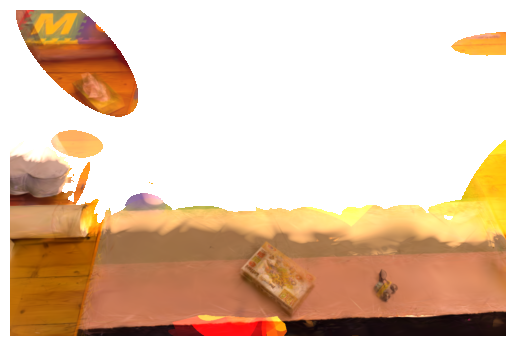

In [13]:
# Display the computed image.
plt.imshow(computed_image)
plt.axis('off')